In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [ ]:
# Now, we add our dataset here. To do that we need to upload the csv file on google colab
from google.colab import files
uploaded = files.upload()

Saving attractions_new.csv to attractions_new.csv


In [ ]:
# read data
attractions_df = pd.read_csv('attractions_new.csv' , sep=',', encoding='utf-8', usecols=['location_id','location_name','ratings','description','best time to visit','location_type','type_id','no. of ratings','user_id','state','Address','website_link','image_link'])
attractions_df.head()

,location_id,location_name,ratings,description,best time to visit,location_type,type_id,no. of ratings,user_id,state,Address,website_link,image_link
0,0,Leh Ladakh,4.6,Ladakh is a union territory in the Kashmir reg...,Jun to Sep,Hill Station,1,139,1,Jammu and Kashmir,"leh ladhak,jammu and kashmir,194101,india",lehladakhindia.com,https://www.holidify.com/images/bgImages/LADAK...
1,1,Srinagar,4.5,"Famously known as 'Heaven on Earth, Srinagar i...",April to October,City,2,126,3,Jammu and Kashmir,"srinagar,jammu and kashmir,190001,india",srinagar.nic.in,https://www.holidify.com/images/bgImages/SRIN...
2,2,Manali,4.5,"With spectacular valleys, breathtaking views, ...",October to June,Hill Station,1,466,3,Himachal Pradesh,"manali,himachal pradesh,175131,india",himachaltourism.gov.in,https://www.holidify.com/images/bgImages/MANA...
3,3,Coorg,4.2,Located amidst imposing mountains in Karnataka...,October to March,Hill Station,1,432,5,Karnataka,"coorg,karnataka,571201,india",coorgtourism.co.in,https://www.holidify.com/images/bgImages/COOR...
4,4,Andaman,4.5,Replete with turquoise blue water beaches and ...,October to Jun,Island,3,135,2,Andaman and Nicobar Islands,"andaman,andamana and nicobar,744209",andamans.gov.in,https://www.holidify.com/images/bgImages/ANDA...


In [ ]:
# drop rows with NaN values for any column, specifically
attractions_df = attractions_df.dropna(how='any')
# Pre-processing step: Removal of '-'
attractions_df.replace({"-": " "}, regex=True)
# Combine three columns namely: location_name, location_type, and provience
# As all of them reveal some information about the attraction
comb_frame = attractions_df.location_name.str.cat(" "+attractions_df.location_type.str.cat(" "+attractions_df.state))
# remove all characters except numbers and alphabets
comb_frame=comb_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [ ]:
comb_frame.head()

0      Leh Ladakh Hill Station Jammu and Kashmir
1                Srinagar City Jammu and Kashmir
2           Manali Hill Station Himachal Pradesh
3                   Coorg Hill Station Karnataka
4     Andaman Island Andaman and Nicobar Islands
Name: location_name, dtype: object

TF-iDF Vectorization



In [ ]:
# Create word vectors from combined frames
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)

In [ ]:
# Perform Elbow method
wcss = {}
# Looping over multiple values of k from 1 to 35
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(X)
    comb_frame["clusters"] = kmeans.labels_
    wcss[k] = kmeans.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


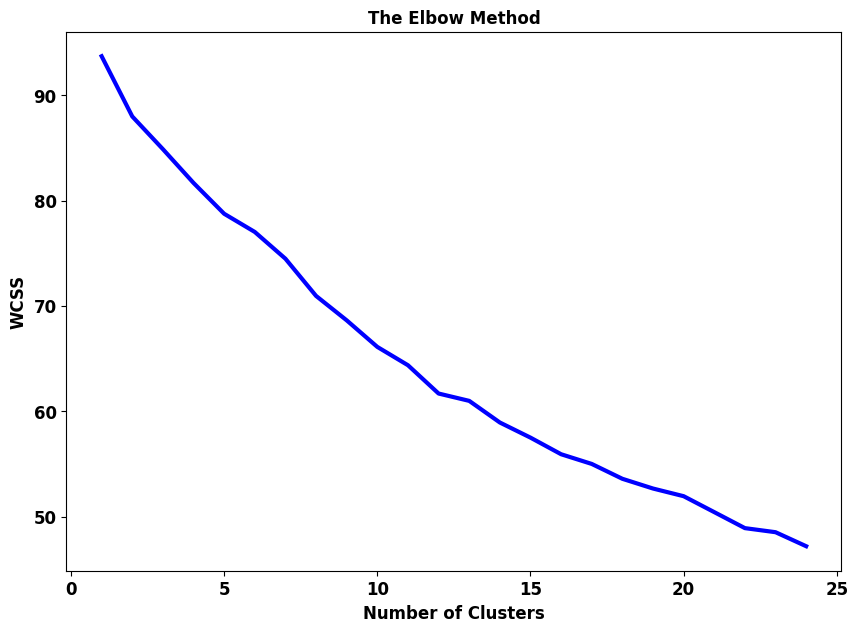

In [ ]:
# Plotting the curve with 'k'-value vs SSE
plt.figure(figsize=(10, 7))
plt.plot(list(wcss.keys()), list(wcss.values()),'b-',lw=3.0)
plt.title('The Elbow Method',fontsize = 12,fontweight='bold')
#plt.xlabel("Number of cluster")
#plt.ylabel("SSE")
plt.xlabel('Number of Clusters',fontsize = 12,fontweight='bold')
plt.ylabel('WCSS',fontsize = 12,fontweight='bold')
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False; mpl.rcParams["axes.spines.top"] = False
from pylab import *
rc('axes', linewidth=3)
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.show()

In [ ]:
# Function to reduce the dimentions of our data usin PCA
def pca(vector):
  from sklearn.decomposition import PCA
  pca_trans = PCA(n_components=2).fit_transform(vector)
  PCA_components = pd.DataFrame(data = pca_trans)
  return pca_trans,PCA_components

In [ ]:
# Function to visulaize and calculate silhouette
def silhouette_vis(PCA_components):
  from sklearn.metrics import silhouette_score,silhouette_samples
  from matplotlib import cm
  for clusters in [10,11,14,16]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    clusterer = KMeans(n_clusters=clusters,init='k-means++')
    cluster_labels = clusterer.fit_predict(PCA_components)
    silhouette_avg = silhouette_score(PCA_components, cluster_labels)
    print('The average silhouette score = {} for {} clusters'.format(silhouette_avg,clusters))

    sample_silhouette_values = silhouette_samples(PCA_components, cluster_labels)

    y_lower = 10
    for i in range(clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette Visualization",fontsize = 12,fontweight='bold')
    ax1.set_xlabel("Silhouette Coefficient",fontsize = 12,fontweight='bold')
    ax1.set_ylabel("Cluster Label",fontsize = 12,fontweight='bold')

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusters)
    ax2.scatter(PCA_components.iloc[:, 0], PCA_components.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='o', alpha=1, s=50, edgecolor='k')


    ax2.set_title("Clusters Visualization",fontsize = 12,fontweight='bold')
    ax2.set_xlabel("PC1",fontsize = 12,fontweight='bold')
    ax2.set_ylabel("PC2",fontsize = 12,fontweight='bold')
    plt.suptitle(("Silhouette analysis for KMeans with clusters = %d" % clusters),fontsize=14, fontweight='bold')
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score = 0.6313885734409794 for 10 clusters


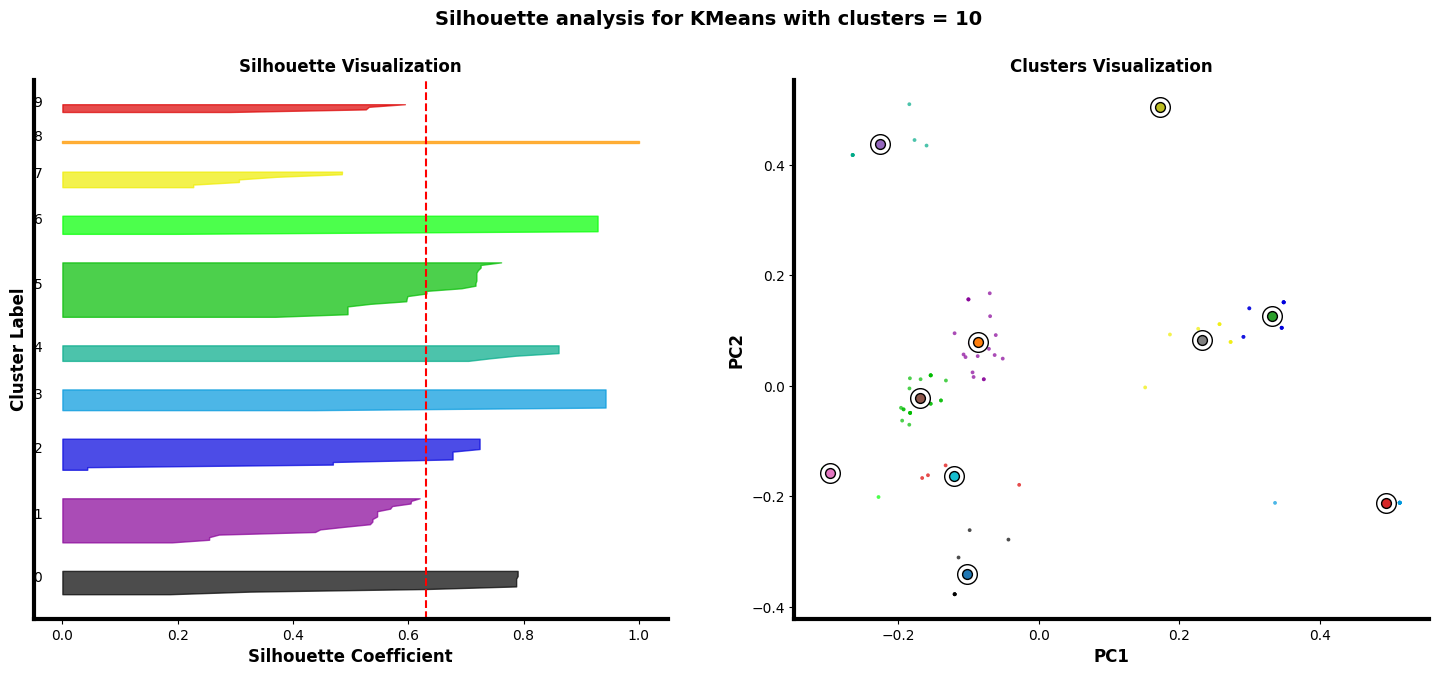

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score = 0.629470127013587 for 11 clusters


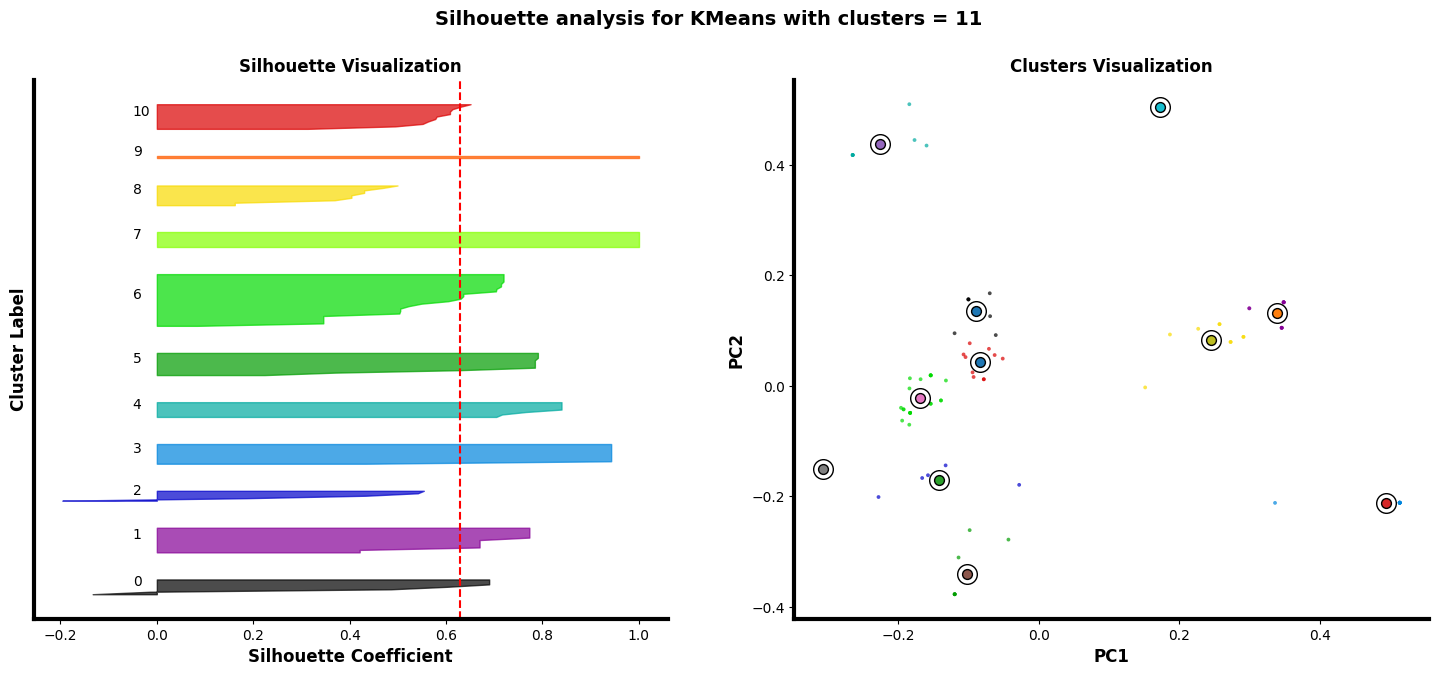

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score = 0.6101752398638406 for 14 clusters


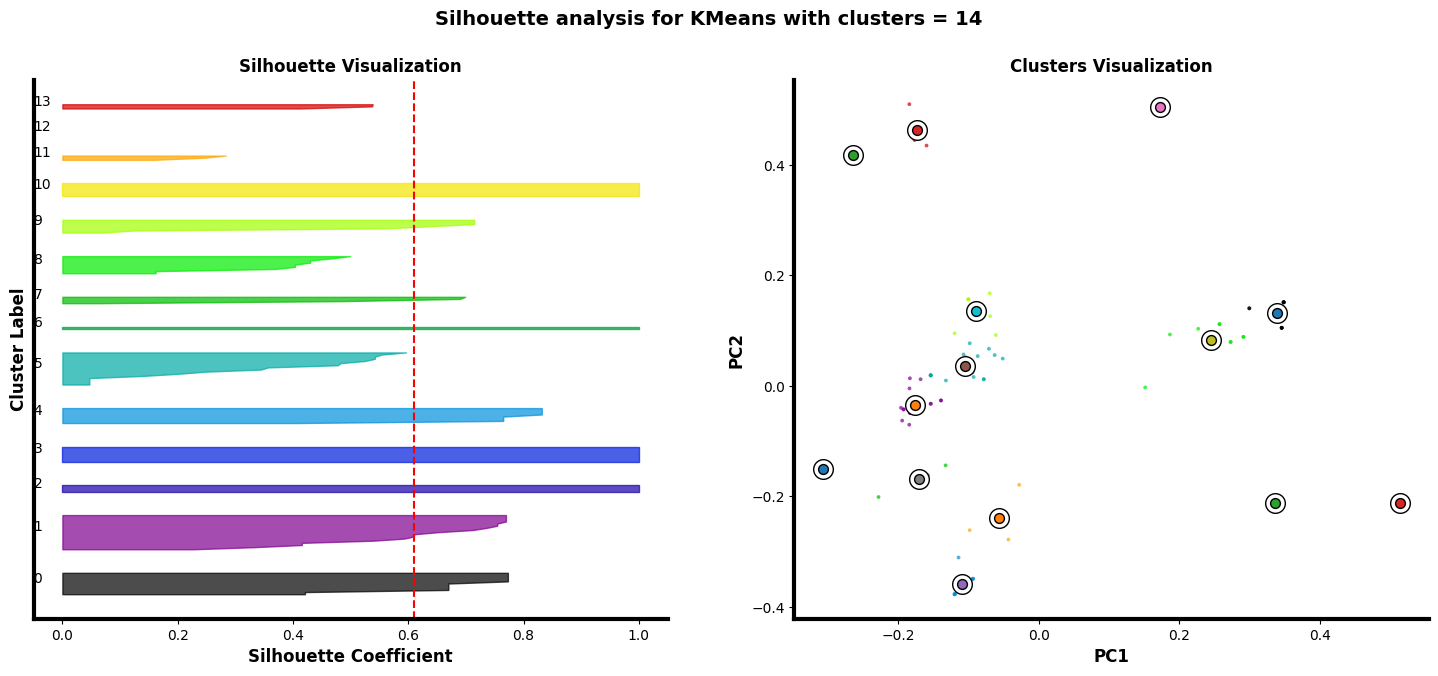

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score = 0.626138560240475 for 16 clusters


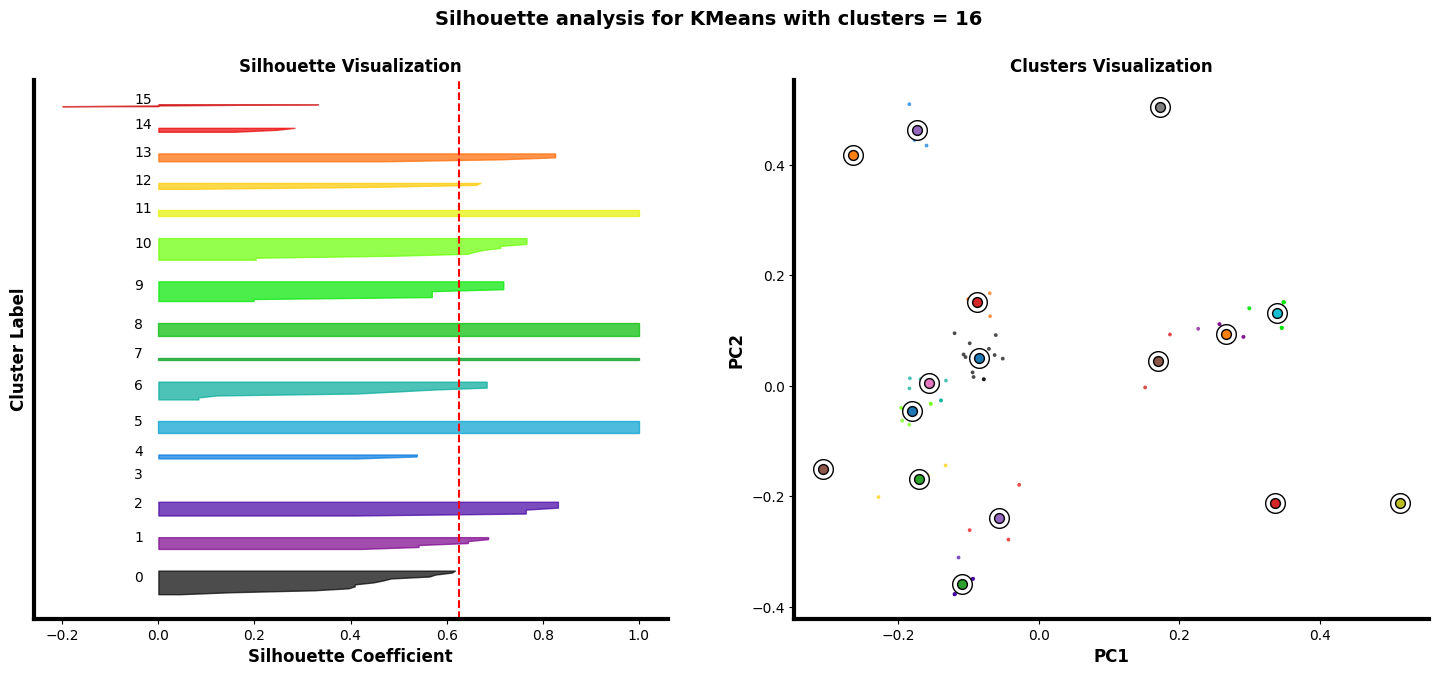

In [ ]:
pca_tfidf,PCA_components_tfidf=pca(X.toarray())
silhouette_vis(PCA_components_tfidf)

Train model with k-means, k=11



In [ ]:
# 5. Train model with k-means
# true_k, derived from elbow method and confirmed from pluralsight's website
true_k = 11
# Running model with 15 different centroid initializations & maximum iterations are 500
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=11)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


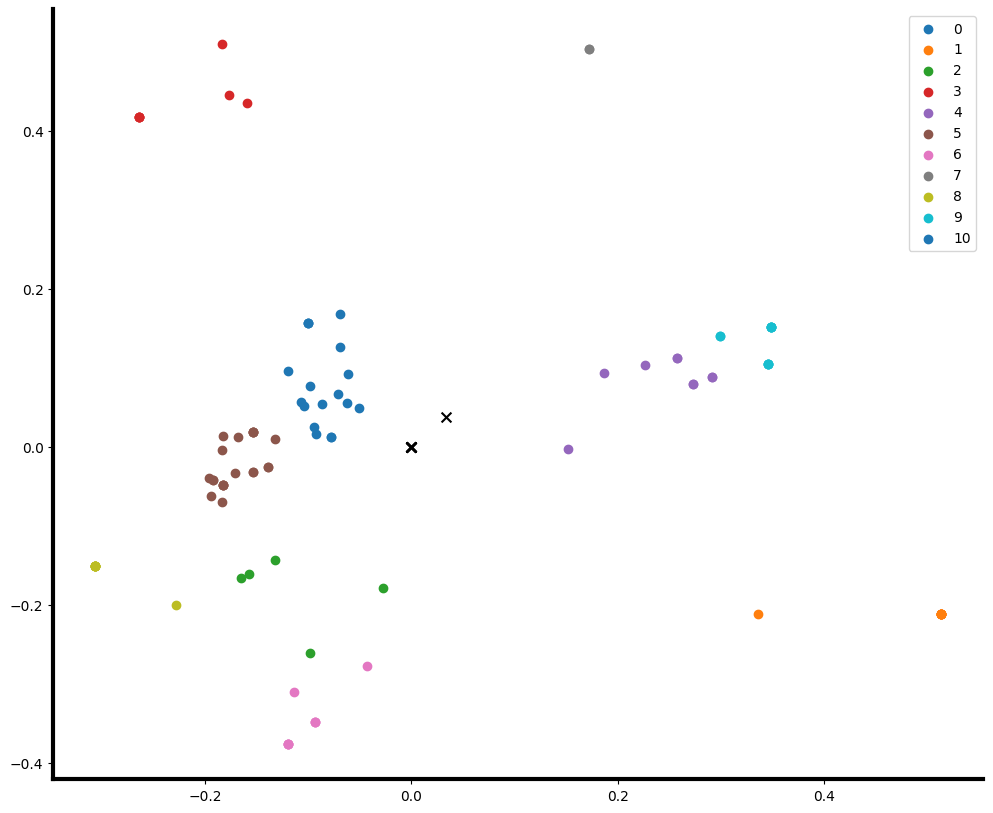

In [ ]:
# Visulize the clusters
from sklearn.decomposition import PCA
pca = PCA(2)
#Transform the data
df = pca.fit_transform(X.toarray())
#predict the labels of clusters.
km_model = KMeans(n_clusters=true_k, init='k-means++')
km_model.fit(df)
label = km_model.fit_predict(df)
#Getting unique labels
u_labels = np.unique(label)
#Getting the Centroids
centroids = model.cluster_centers_
u_labels = np.unique(label)
#plotting the results:
plt.figure(figsize=(12,10))
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] ,marker='x', s = 50, color = 'k')
plt.legend()
plt.show()

In [ ]:
# Preview top 15 words in each cluster, and accordingly different clusters can be assigned
print("Top 15 words per cluster:\n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    lst=[]
    for ind in order_centroids[i, :15]:
        lst.append(terms[ind])
    print(lst,'\n')


Top 15 words per cluster:

Cluster 0:
['himachal', 'pradesh', 'hill', 'station', 'dharamshala', 'mcleodganj', 'manali', 'shimla', 'nahan', 'dalhousie', 'kasauli', 'kasol', 'pachmarhi', 'madhya', 'ellora'] 

Cluster 1:
['nadu', 'tamil', 'city', 'thanjavur', 'madurai', 'coimbatore', 'chennai', 'ooty', 'kodaikanal', 'rameshwaram', 'kanyakumari', 'hogenakkal', 'hill', 'station', 'waterfall'] 

Cluster 2:
['national', 'park', 'ranthambore', 'rajasthan', 'gir', 'kanha', 'kaziranga', 'assam', 'jim', 'corbett', 'gujarat', 'madhya', 'uttarakhand', 'pradesh', 'ellora'] 

Cluster 3:
['jammu', 'kashmir', 'pilgrimage', 'srinagar', 'gulmarg', 'amarnath', 'leh', 'ladakh', 'devi', 'vaishno', 'station', 'hill', 'city', 'haridwar', 'gaya'] 

Cluster 4:
['maharashtra', 'hill', 'station', 'uttarakhand', 'city', 'nashik', 'pune', 'mumbai', 'aurangabad', 'matheran', 'lonavala', 'lavasa', 'mahabaleshwar', 'khandala', 'auli'] 

Cluster 5:
['city', 'rajasthan', 'uttarakhand', 'delhi', 'chandigarh', 'pushkar', 

Prediction

In [ ]:
def cluster_predict(str_input):
    Y = vectorizer.transform(list(str_input))
    prediction = model.predict(Y)
    return prediction

In [ ]:
# create new column in dataframe which is combination of (location_name, location_type, provience) in existing data-frame
attractions_df['Input_Text'] = attractions_df.location_name.str.cat(" "+attractions_df.location_type.str.cat(" "+attractions_df.state))
# Create new column for storing predicted categories from our trained model.
attractions_df['Predicted_Clusters'] = ""
# Cluster category for each attraction
attractions_df['Predicted_Clusters'] = attractions_df.apply(lambda x: cluster_predict(x['Input_Text']), axis=1)

In [ ]:
attractions_df.sample(5)

,location_id,location_name,ratings,description,best time to visit,location_type,type_id,no. of ratings,user_id,state,Address,website_link,image_link,Input_Text,Predicted_Clusters
61,61,Kasol,4.4,Kasol is a quaint little village in Himachal s...,October to June,Hill Station,1,95,1,Himachal Pradesh,"kasol,himachal pradesh,175105,india",kasolhimachal.com,https://www.holidify.com/images/bgImages/KASO...,Kasol Hill Station Himachal Pradesh,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
64,64,Tirupati,4.5,Situated in the Chittoor district of Andhra Pr...,September to March,Pilgrimage,6,202,3,Andhra Pradesh,"tirupati,andhra pradesh,517101,india",tirupati.ap.gov.in,https://www.holidify.com/images/bgImages/TIRU...,Tirupati Pilgrimage Andhra Pradesh,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
55,55,Shirdi,4.4,Located at a distance of 122 Km from Nasik in ...,July to March,Pilgrimage,6,116,2,Maharashtra,"shirdi,maharashtra,423109,india",shirdisaibaba.org,https://www.holidify.com/images/bgImages/SHIR...,Shirdi Pilgrimage Maharashtra,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
4,4,Andaman,4.5,Replete with turquoise blue water beaches and ...,October to Jun,Island,3,135,2,Andaman and Nicobar Islands,"andaman,andamana and nicobar,744209",andamans.gov.in,https://www.holidify.com/images/bgImages/ANDA...,Andaman Island Andaman and Nicobar Islands,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
99,99,Agartala,3.8,"Home to the Manikya Kings in the past, Agartal...",Throughout the year,City,2,30,4,Tripura,"agartala,tripura,799001,india",tripuratourism.gov.in,https://www.holidify.com/images/bgImages/AGAR...,Agartala City Tripura,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


Recommend

In [ ]:
def recommend(str_input):

  # Predict category of input string category
  temp_df = attractions_df.loc[attractions_df['location_name'] == str_input]
  temp_df['Input_Text'] = temp_df.location_name.str.cat(" "+temp_df.location_type.str.cat(" "+temp_df['state']))
  str_input = list(temp_df['Input_Text'])

  prediction_inp = cluster_predict(str_input)
  prediction_inp = int(prediction_inp)

  temp_df = attractions_df.loc[attractions_df['Predicted_Clusters'] == prediction_inp]
  if len(temp_df)<5:
    temp_df = temp_df.sample(len(temp_df))
  else:
    temp_df = temp_df.sample(5)

  return list(temp_df['location_name'])

In [ ]:
queries = ['Mysore', 'Mumbai',
           'Banglore']

for query in queries:
    res = recommend(query)
    print("We have {} recommenations for [{}]:".format(len(res),query))
    print(res,'\n')

ValueError: ignored